In [15]:
import muselsl
import vispy
import pandas as pd
import os
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import mne
from typing import Union, List, Dict
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.filter import create_filter
import copy
from copy import deepcopy

In [8]:
# steps
# separate the eeg time data into frequency data
# read the emotion classification paper on what to do next

In [10]:
def load_csv_as_raw(
    fnames: List[str],
    sfreq: float,
    ch_ind,
    aux_ind=None,
    replace_ch_names=None,
    verbose=1,
    resp_on_missing='warn'
) -> RawArray:
    """Load CSV files into an MNE Raw object.
    Args:
        fnames (array_like): list of filename(s) to load. Should end with
            ".csv".
        sfreq (float): sampling frequency of the data.
        ch_ind (array_like): column indices to keep from the CSV files.
    Keyword Args:
        aux_ind (array_like or None): list of indices for columns containing
            auxiliary channels.
        replace_ch_names (array_like or None): list of channel name mappings
            for the selected columns.
        verbose (int): verbose level.
    Returns:
        (mne.io.RawArray): concatenation of the specified filenames into a
            single Raw object.
    """


    print('\n\nLoading these files: \n')
    for f in fnames: print(f + '\n')
    print('\n\n')


    ch_ind = copy.deepcopy(ch_ind)
    n_eeg = len(ch_ind)
    if aux_ind is not None:
        n_aux = len(aux_ind)
        ch_ind += aux_ind
    else:
        n_aux = 0

    raw = []

    for fn in fnames:
        # Read the file
        data = pd.read_csv(fn)

        # Channel names and types
        ch_names = [list(data.columns)[i] for i in ch_ind] + ["stim"]
        print(ch_names)
        ch_types = ["eeg"] * n_eeg + ["misc"] * n_aux + ["stim"]

        if replace_ch_names is not None:
            ch_names = [
                c if c not in replace_ch_names.keys() else replace_ch_names[c]
                for c in ch_names
            ]
        print(ch_names)

        # Transpose EEG data and convert from uV to Volts
        data = data.values[:, ch_ind + [-1]].T
        data[:-1] *= 1e-6

        # create MNE object
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, verbose=1)
        raw.append(RawArray(data=data, info=info, verbose=verbose))
    
    raws = concatenate_raws(raw, verbose=verbose)
    montage = make_standard_montage("standard_1005")
    raws.set_montage(montage,on_missing=resp_on_missing)

    return raws


In [9]:
data_5s = pd.read_csv('EEG_recording_2023-04-12-09.09.57.csv', index_col='timestamps', usecols=[0,1,2,3,4])
data_10s = pd.read_csv('EEG_recording_2023-04-12-09.12.24.csv', index_col='timestamps', usecols=[0,1,2,3,4])
data_30s = pd.read_csv('EEG_recording_2023-04-12-09.11.08.csv', index_col='timestamps', usecols=[0,1,2,3,4])
nihala = pd.read_csv('data/nihala_2023-04-12-09.55.25.csv',  index_col='timestamps', usecols=[0,1,2,3,4])

In [8]:
data_5s.head()

,TP9,AF7,AF8,TP10
timestamps,,,,
1.681291e+09,-26.855,-28.320,-39.062,-18.555
1.681291e+09,-21.484,-29.297,-32.227,-16.602
1.681291e+09,-21.484,-30.273,-30.273,-27.832
1.681291e+09,-20.020,-18.066,-33.691,-34.180
1.681291e+09,-13.672,-18.555,-35.156,-36.621


In [19]:
ch_names = ['TP9', 'AF7', 'AF8', 'TP10']
ch_inds = [1,2,3,4]
sfreq = 256
# info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types='eeg')
# raw = mne.io.RawArray(data_30s.values.T, info)

In [20]:
raw = load_csv_as_raw(['EEG_recording_2023-04-12-09.11.08.csv'], sfreq, ch_inds)



Loading these files: 

EEG_recording_2023-04-12-09.11.08.csv




['TP9', 'AF7', 'AF8', 'TP10', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=6432
    Range : 0 ... 6431 =      0.000 ...    25.121 secs
Ready.


In [17]:
# t = np.array(nihala.index)
# x = np.array(nihala['TP9'])
# X = fft(x)
# # Plot the amplitude spectrum
# freqs = np.fft.fftfreq(len(x), t[1]-t[0])
# plt.plot(freqs[:len(freqs)//2], np.abs(X[:len(X)//2]))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.show()

In [21]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10, stim
 chs: 4 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 256.0 Hz
>

In [24]:
spectrum = raw.compute_psd(method='multitaper')

    Using multitaper spectrum estimation with 7 DPSS windows


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


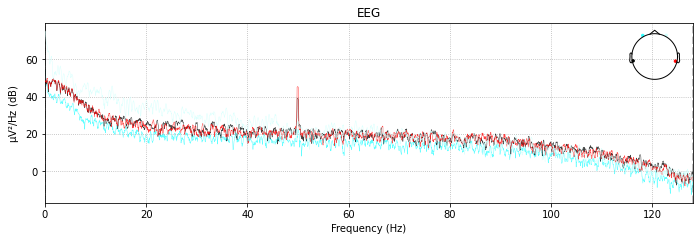

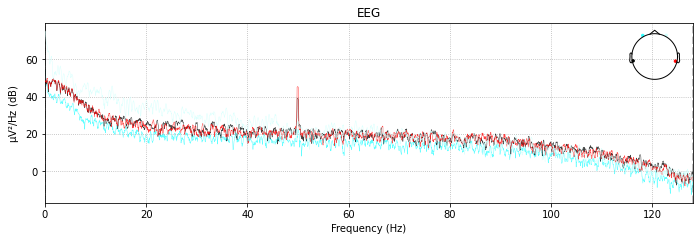

In [25]:
spectrum.plot()

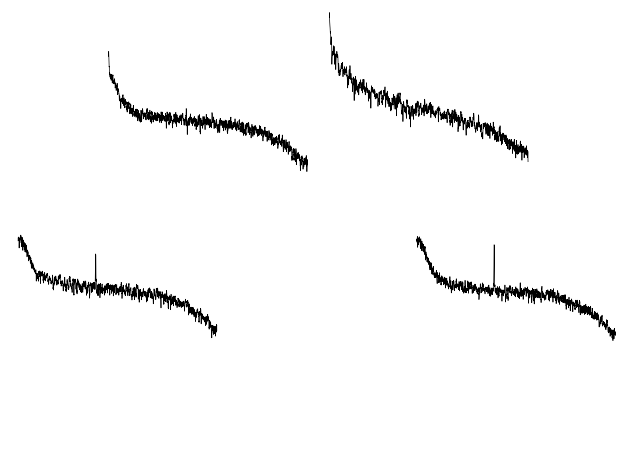

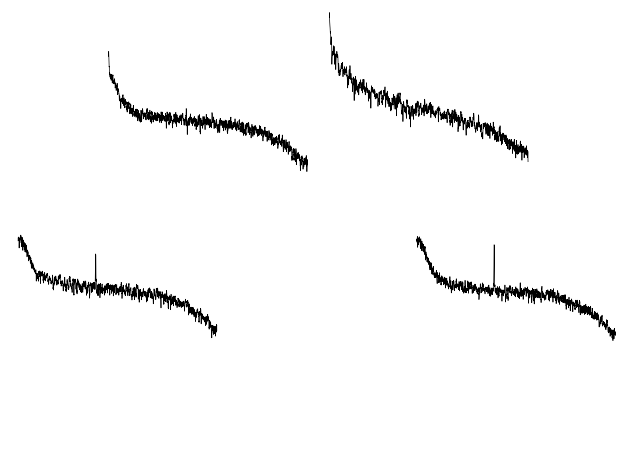

In [28]:
spectrum.plot_topo(color='k', fig_facecolor='w', axis_facecolor='w')

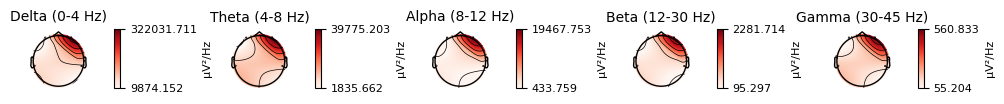

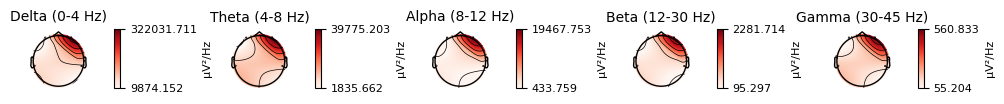

In [30]:
spectrum.plot_topomap(ch_type='eeg', agg_fun=np.median)